In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load MNIST dataset, but only keep digits 0 and 8
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter out only the digits 0 and 8
train_indices = np.where((mnist_train.targets == 0) | (mnist_train.targets == 8))[0]
test_indices = np.where((mnist_test.targets == 0) | (mnist_test.targets == 8))[0]

train_data = mnist_train.data[train_indices]
train_targets = mnist_train.targets[train_indices]
test_data = mnist_test.data[test_indices]
test_targets = mnist_test.targets[test_indices]

# Normalize the data to [0, 1]
train_data = train_data.float() / 255.0
test_data = test_data.float() / 255.0

# Flatten the images to vectors of size 784
train_data = train_data.view(-1, 28*28)
test_data = test_data.view(-1, 28*28)

# Convert targets to binary: 0 for '0' and 1 for '8'
train_targets = (train_targets == 8).float().view(-1, 1)
test_targets = (test_targets == 8).float().view(-1, 1)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:08<00:00, 1214495.92it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 220216.29it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 883539.40it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1500514.24it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [6]:
# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 1)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize the networks
net_hinge = SimpleNN()
net_ce = SimpleNN()
net_exp = SimpleNN()

# Initialize weights with Gaussian distribution
for net in [net_hinge, net_ce, net_exp]:
    for layer in net.modules():
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight, mean=0, std=1/np.sqrt(layer.in_features + layer.out_features))
            nn.init.zeros_(layer.bias)

# Loss functions
def hinge_loss(output, target):
    return torch.mean(torch.clamp(1 - output * (2 * target - 1), min=0))

def exponential_loss(output, target):
    return torch.mean(torch.exp(-output * (2 * target - 1)))

criterion_ce = nn.BCELoss()

# Training function with loss tracking
def train_network(net, criterion, optimizer, train_data, train_targets, epochs=50):
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(train_data)
        loss = criterion(outputs, train_targets)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    return loss_history

# Optimizers
optimizer_hinge = optim.Adam(net_hinge.parameters(), lr=0.001)
optimizer_ce = optim.Adam(net_ce.parameters(), lr=0.001)
optimizer_exp = optim.Adam(net_exp.parameters(), lr=0.001)

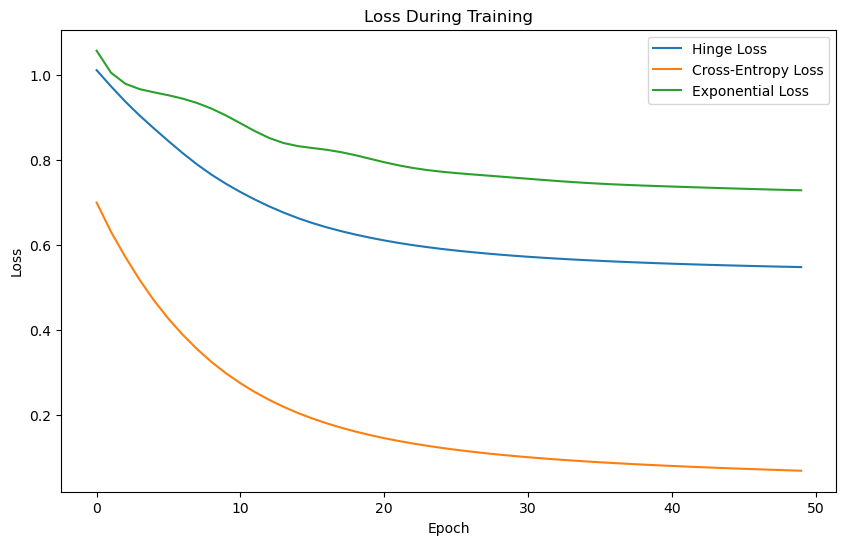

In [7]:
# Train the networks
loss_history_hinge = train_network(net_hinge, hinge_loss, optimizer_hinge, train_data, train_targets, epochs=50)
loss_history_ce = train_network(net_ce, criterion_ce, optimizer_ce, train_data, train_targets, epochs=50)
loss_history_exp = train_network(net_exp, exponential_loss, optimizer_exp, train_data, train_targets, epochs=50)

# Plot the loss histories
plt.figure(figsize=(10, 6))
plt.plot(range(50), loss_history_hinge, label='Hinge Loss')
plt.plot(range(50), loss_history_ce, label='Cross-Entropy Loss')
plt.plot(range(50), loss_history_exp, label='Exponential Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()